In [2]:
import numpy as np
import math
from IPython.core.debugger import Tracer
import warnings
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')


this notebook implements the calculation of Correlation as detailed in: 
Flow-adaptive moderation of spurious ensemble correlations and its use in ensemble-based data assimilation†
Craig H. Bishop* and Daniel Hodyss

In [5]:
# read python dict containing measurements
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"


Shape of Vector of Ensembles: (450, 37, 73)


In [46]:


# form X matrix: columns are ensemble members, and each solumn is the spatial grid flattened into a col vector
#K = num_of_ensembles
#n = num_of_lat*num_of_lon, or 2nd & third ensemble dimension, or just 2nd dimension if no 3rd
def calc_sample_corr_mat(K, n, ensemble, smooth_bool):
    
    X = ensemble.reshape(K, n).T #n by K 
    
    #Gaussian Filter Smoothing-------
    #smoothing Perturbations (P) by smoothing each ensemble member's perturbation separately
    #not sure if supposed to smooth ensemble prior to making P (doing this), or after making P
    #paper says "The ensemble was smoothed by applying a Gaussian spectral filter to each ensemble member"
    #AND says "LetW? = [w1?,w2?,...,wK?]define K smooth pertur-bations"
    #so could mean smoothing perturbations (P) or smoothing ensemble (doing latter)
    if smooth_bool == True:
        
        for ii in range(K):
        
            col = X[:,ii]
            col = col.reshape(num_of_lat, num_of_lon)
            new_col = filters.gaussian_filter(col, 2) #smoothing w/ standard deviation of 10 degrees (2 indices)
            new_col = new_col.reshape(n)
            X[:,ii] = new_col

    
    #determine ensemble mean: column vector mean, mean across ensemble/columns

    x_bar = np.mean(X, axis=1).reshape(n, 1)

    #prep mean to be subtracted from X by tiling it 
    x_bar_tiled = np.tile(x_bar, K)

    X_prime = X - x_bar_tiled


    #form ensemble perturbations matrix 
    
    summ = np.zeros((n, n))
    for ii in range(K):

        col_vec = X_prime[:,ii].reshape(n, 1)
        summ = summ + np.dot(col_vec, col_vec.T)


    P = (1/(K-1)) * summ
    print(np.shape(P))
    
    


    #calculate sample standard deviation (Eq. 3)
    #vector of s_j, col vector bc sum across ensemble/cols for each row
    S = np.sqrt( (1/(K-1)) *  np.sum(P**2, axis = 1) ) 
    S = S.reshape(n, 1)


    #calc normalized [spatio-]temporally smoothed ensemble perturbations (Eq. 4)
    #not completely b/c did not smooth spatially to obtain W, just using P

    #begin by tiling S over all rows, to divide each entire column of P by an S value
    #Use X_prime is W_prime matrix? raw perturbations instead of "smoothed" perturbations? will continue like this
    S_tiled = np.tile(S, (1, K))

    W_tilde = X_prime/S_tiled


    
    
    #form sample correlation matrix: C_s (Eq. 5)

    summ = np.zeros((n, n))
    for ii in range(K):

        col_vec = W_tilde[:,ii].reshape(n, 1)
        summ = summ + np.dot(col_vec, col_vec.T)


    C_s = (1/(K-1)) * summ


    return C_s


# form X matrix: columns are ensemble members, and each solumn is the spatial grid flattened into a col vector
K = num_of_ensembles
n = num_of_lat*num_of_lon
smooth = True

ensembles_of_density_grid_normalized = ensembles_of_density_grid * 1e13
C_s = calc_sample_corr_mat(K, n, ensembles_of_density_grid_normalized, smooth)

(2701, 2701)


In [47]:

if smooth:
    filename = "Data Files/ensemble_cor_smooth.mat"
else:
     filename = "Data Files/ensemble_cor.mat"   

import scipy.io
scipy.io.savemat(filename, mdict={'cor_mat': C_s, 'density': ensembles_of_density_grid, \
                                        'latitude_grid': latitude_grid, 'longitude_grid': longitude_grid})



#C_s_pow = C_s**2

In [ ]:
x = np.arange(0, n, 1)
y = np.arange(0, n, 1)

X, Y = np.meshgrid(x, y)


fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, C_s)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Correlation', fontsize=18)
ax.set_title('Correlations', fontsize=16)
plt.show()

In [21]:
#y=amplitude×sin(frequency×time+phase)+bias

times = np.arange(0,50,.1)

amplitudes = np.random.rand(10)
#frequencies = np.random.rand(10)
frequency = .5
biases = np.random.rand(10)*.2


members = len(amplitudes) * len(biases)
sine_ensemble = np.zeros((len(amplitudes), len(biases), len(times)))

for ii in range(len(amplitudes)):
    
    for jj in range(len(biases)):
        
        #for kk in range(len(times)):
            
        y = amplitudes[ii] * np.sin(times) + biases[jj]
        
        sine_ensemble[ii, jj, :] = y
        
        


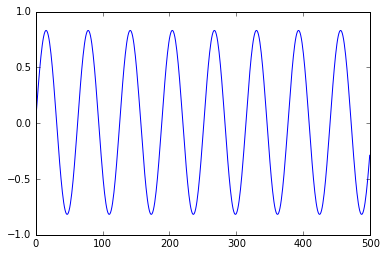

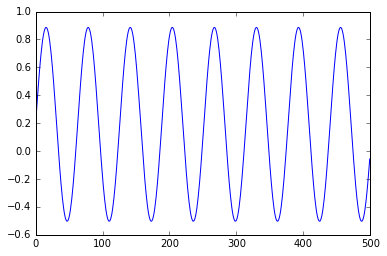

In [15]:

plt.plot(sine_ensemble[1,:])
plt.show()


plt.plot(sine_ensemble[10,:])
plt.show()


In [16]:

K = members
n = len(times)

C_s = calc_sample_corr_mat(K, n, sine_ensemble)



(500, 500)


In [ ]:
plt.plot(C_s[10,:])
plt.show()

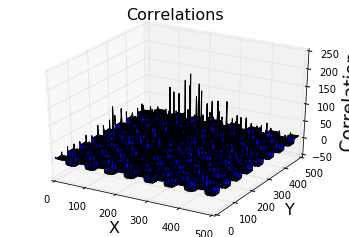

In [22]:

x = np.arange(0, n, 1)
y = np.arange(0, n, 1)

X, Y = np.meshgrid(x, y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, C_s)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Correlation', fontsize=18)
ax.set_title('Correlations', fontsize=16)
plt.show()

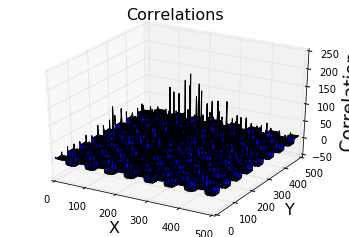

In [18]:
x = np.arange(0, n, 1)
y = np.arange(0, n, 1)

X, Y = np.meshgrid(x, y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, C_s)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Correlation', fontsize=18)
ax.set_title('Correlations', fontsize=16)
plt.show()

In [33]:
a = np.array([[1,2, 3, 44, 35, 15, 2, 60, 10, 45], \
              [4,6, 8, 30, 28, 20, 4, 30, 20, 5]])

b = np.array([[1,50, 3, 44, 35, 15, 2, 60, 10, 45], \
              [4,60, 8, 30, 28, 20, 4, 30, 20, 5]])
c = np.append(a, b).reshape(2, 2, 10)
print(c)

print(filters.gaussian_filter(c, [.5,1]))
print('********')

c = np.append(a, a*4).reshape(2, 2, 10)
print(c)

print(filters.gaussian_filter(c, .5))

[[[ 1  2  3 44 35 15  2 60 10 45]
  [ 4  6  8 30 28 20  4 30 20  5]]

 [[ 1 50  3 44 35 15  2 60 10 45]
  [ 4 60  8 30 28 20  4 30 20  5]]]


RuntimeError: sequence argument must have length equal to input rank